In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Printing/output settings

In [14]:
pd.set_option('display.max_colwidth', None)

# Explanatory Data Analysis

### Load data

We will load only positives reviews (rating > 3) from the database.

In [36]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect("initial_data/database.sqlite"))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

Each podcast has multiple categories so we will concatenate them 
into a single string and will handle them as a single category for now.

In [37]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()

# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

### Removing duplicates reviews
Users might review a podcast more than once. We keep only the latest review.

In [38]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 59619 duplicates ~ 0.033% of total reviews


### Removing reviews with podcast_id not in podcasts table
There are reviews that their podcast id is not in the podcast table so we do not have any info about them.

In [39]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 21579 reviews ~ 0.012% of total reviews


### Keeping only authors with more than N reviews

In [42]:
# Keep only authors with at least K reviews
K = [4, 5, 6, 7, 8, 9, 10]
info = []
K = 4
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)



In [19]:
# Keep only authors with at least K reviews
K = 5
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)

In [20]:
# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

Unique authors: 18551
Unique reviews: 156646


### Creating the final dataset

In [21]:
# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)

In [35]:
# print unique authors
print(f'Unique authors: {reviews_w_podcast_w_category["author_id"].unique().shape[0]}')

Unique authors: 18551


In [22]:
# clean memory
del  reviews
del podcast_w_category

Cluster based on the K most recent reviews\
We will represent each author as a vector of size K, where each element is a podcast category\
We will use KModes to cluster the authors


### Clustering

In [23]:
def prepare_data_for_clustering(data, K):
    """
    data: dataframe with columns author_id, podcast_id, p_title, category, rating, created_at
    K: number of most recent reviews to consider
    """
    # get the K most recent reviews for each author
    data = data.copy()
    data = data.groupby('author_id').head(K)
    authors = data['author_id'].unique()
    total_authors = authors.shape[0]
    print(f'Unique authors: {total_authors} with >={K} reviews')

    # get the most frequent categories
    category_freq = reviews_w_podcast_w_category['category'].str.split('#').explode().value_counts().to_dict()

    # For each podcast category split the concatenated string into a list of categories and keep the 
    # most frequent category as the category of the podcast
    data = data[['author_id', 'category', 'created_at']]
    data['category'] = data['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
    

    # represent each author as a vector of K categories
    matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
    matrix_K_categories = matrix_K_categories.fillna("empty")
    # fill the matrix with the average rating of the author for the podcast title in order
    for index, author in enumerate (authors):
        index = index + 1
        categories = data[data['author_id'] == author]['category'].values
        for i in range(K):
            matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
        if index % 3000 == 0:
            print(f'{index} authors processed')    


    return matrix_K_categories

In [24]:
# matrix_K_categories = prepare_data_for_clustering(reviews_w_podcast_w_category, 5)

In [25]:
def clustering(data, num_of_clusters, plot=False):
    # Categorical data clustering
    # Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
    # Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

    data = data.astype('str')

    from kmodes.kmodes import KModes
    import matplotlib.pyplot as plt
    import numpy as np

    centroids = None

    import time

    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=num_of_clusters, init = 'random', verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(data)
    end_time = time.time()
    # info about the clustering
    print(f"For K: {num_of_clusters} and init method random-> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    centroids = kmodes.cluster_centroids_
    #print(f"Centroids: {centroids}")
    # get labels
    data['cluster'] = kmodes.labels_

    data = data.reset_index()
    data = data.rename(columns={'index': 'author_id'})
    data = data[['author_id', 'cluster']]
    cost = kmodes.cost_
    return data, centroids, cost


In [26]:
cluster_Ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
matrix_K_categories = prepare_data_for_clustering(reviews_w_podcast_w_category, K)
cost_per_K = []
for K in cluster_Ks:
    print(f'Clustering for K={K}')
    data, centroids, cost = clustering(matrix_K_categories, K)
    cost_per_K.append(cost)

Unique authors: 18551 with >=5 reviews
3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed
Clustering for K=1
For K: 1 and init method random-> Max iterations: 1  Cost: 72413.0 Time: 0.371 minutes
Clustering for K=2
For K: 2 and init method random-> Max iterations: 1  Cost: 64461.0 Time: 0.486 minutes
Clustering for K=3
For K: 3 and init method random-> Max iterations: 2  Cost: 58311.0 Time: 0.601 minutes
Clustering for K=4
For K: 4 and init method random-> Max iterations: 3  Cost: 55773.0 Time: 0.659 minutes
Clustering for K=5
For K: 5 and init method random-> Max iterations: 3  Cost: 53449.0 Time: 0.659 minutes
Clustering for K=6
For K: 6 and init method random-> Max iterations: 2  Cost: 52954.0 Time: 0.821 minutes
Clustering for K=7
For K: 7 and init method random-> Max iterations: 4  Cost: 50984.0 Time: 0.806 minutes
Clustering for K=8
For K: 8 and init method random-> Max iterations: 4  Cost: 

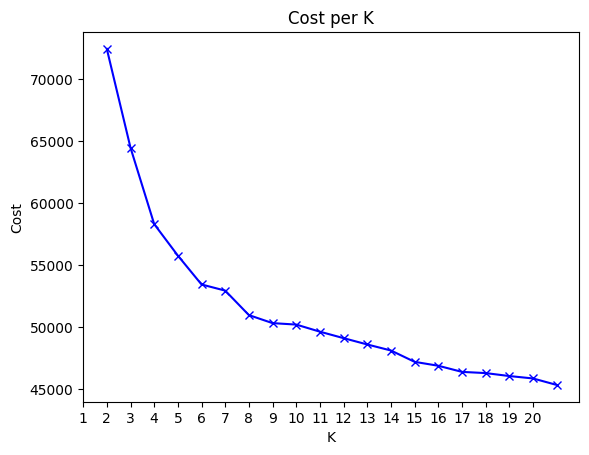

In [34]:
# plot costs with x axis integer values
import matplotlib.pyplot as plt

plt.plot(cluster_Ks, cost_per_K, 'bx-')
plt.xlabel('K')
plt.ylabel('Cost')
plt.title('Cost per K')
default_x_ticks = range(len(cluster_Ks))
plt.xticks(default_x_ticks, cluster_Ks)
plt.show()



In [28]:
authors_clustered, centroids = clustering(matrix_K_categories, 7)

For K: 7 and init method random-> Max iterations: 4  Cost: 50984.0 Time: 0.79 minutes


ValueError: too many values to unpack (expected 2)

In [ ]:
print(centroids)
print(authors_clustered.head())

[['comedy' 'comedy' 'comedy' 'society-culture' 'comedy']
 ['sports' 'sports' 'sports' 'sports' 'sports']
 ['news' 'news' 'news' 'news' 'news']
 ['society-culture' 'society-culture' 'society-culture' 'society-culture'
  'society-culture']
 ['kids-family' 'kids-family' 'kids-family' 'arts' 'kids-family']
 ['business' 'business' 'business' 'business' 'business']
 ['tv-film' 'tv-film' 'tv-film' 'tv-film' 'tv-film']]
         author_id  cluster
0  FFF559CD2875885        3
1  FFF171657D896FA        0
2  FFEF1081D4828D2        1
3  FFEE0B290529BDE        1
4  FFE6F75290CFE09        6


In [ ]:
# print index FFF559CD2875885 from matrix_K_categories
print(matrix_K_categories.loc['FFE6F75290CFE09'])

category_0    society-culture
category_1            tv-film
category_2    society-culture
category_3            tv-film
category_4            tv-film
Name: FFE6F75290CFE09, dtype: object
